In [72]:
# Darren Chan
# Based on https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/
# and 
# https://www.nature.com/articles/s41598-021-94609-3


import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# SIR model ODEs
def deriv(y, t, N, beta, gamma, summation_value):
    S, I, R = y
    dSdt = -beta * S * (I / N) * summation_value
    dIdt = beta * S * (I / N) * summation_value - (gamma * I)
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Age-Structured SIR equations summation
def summationOfGroup(CONTACT_MATRIX, groupIdx, boro_group_rate):
    sum = 0
    for j in range(len(CONTACT_MATRIX)):
        sum += CONTACT_MATRIX.item(groupIdx, j) * boro_group_rate[j]
        
    return sum

# Plotting for some function F
def plot(t, F, labeltext, filename):
    plt.xlabel("Days")
    plt.ylabel("Infected Proportion (%)")
    plt.plot(t, F, alpha=0.7, linewidth=3, label = labeltext)
    plt.legend(loc = "upper right")
    plt.title(str(filename))
    plt.savefig(str(filename), dpi=1200)

# CM = contact matrix with or without relaxed brackets
# BORO_AGE_POP = population array for each age bracket
# BORO_GRP_RATE = population infection rate array for each age bracket
def integration(CM, BORO_AGE_POP, BORO_GRP_RATE):
    resultant = np.matmul(CM, np.diag(BORO_AGE_POP)) 
    eigvals, eigvecs = np.linalg.eig(resultant)
    boro_lambda = max(eigvals) # dominant eigenvalue

    beta = Rnaught * gamma / boro_lambda # beta for borough

    totalI = 0
    for idx in range(len(CM)):
        # Integrate the SIR equations over the time grid, t.
        S0 = N * BORO_AGE_POP[idx]
        y0 = S0, I0, R0 # Initial conditions vector

        ret = odeint(deriv, y0, t, 
                     args=(N*BORO_AGE_POP[idx], beta, gamma, summationOfGroup(CM, idx, BORO_GRP_RATE)))

        S, I, R = (ret.T / N) * 100
        totalI += I
        
    return totalI

In [73]:
# Total population, N.
N =  100000      

# Initial Conditions: one infected, rest susceptible
S0, I0, R0 = N-1, 1, 0  

# Initial Conditions vector
y0 = S0, I0, R0 

# COVID-19 R naught
Rnaught = 5.7     
# COVID-19 gamma
gamma = 1/14

CITY_CASE_RATE = 12611.06 / N

# Percentage of Age Population by Borough (from CUNY Baruch)
BROOKLYN_AGE_POP = [.13, .115, .152, .166, .124, .111, .101, .063, .036]
BRONX_AGE_POP = [.134, .139, .154, .14, .124, .123, .095, .058, .034]
MANHATTAN_AGE_POP = [.084,.008,.183,.185,.127,.117,.103,.074,.048]
QUEENS_AGE_POP = [.113, .107, .136, .15, .132, .139, .113, .069, .044]
SI_AGE_POP = [.116, .123, .129, .131, .127, .143, .12, .072, .039]
NYC_AGE_POP = [.1154, .1128, .1508, .1544, .1268, .1266, .1064, .0672, .0402]

# Rate of Infection per 100k per Age Group
BROOKLYN_GRP_RATE = [.0842, .1314, .1652, .1600, .1568, .1506, .1407, .1355, .1366]
BRONX_GRP_RATE = [.0878, .1250, .1654, .1830, .1850, .1793, .1643, .1468, .1423]
MANHATTAN_GRP_RATE = [.0757, .1182, .1450, .1243, .1130, .1082, .0945, .0862, .0900]
QUEENS_GRP_RATE = [.0903, .1372, .1770, .1785, .1757, .1618, .1382, .1204, .1173]
SI_GRP_RATE = [.1346, .2080, .2617, .2522, .2338, .2050, .1655, .1435, .1445]
NYC_GRP_RATE = [.0945, .1439, .1828, .1796, .1729, .1610, .1406, .1265, .1262]

# Contact Matrix
CONTACT_MATRIX = np.matrix([[19.2, 4.8, 3.0, 7.1, 3.7, 3.1, 2.3, 1.4, 1.4],
                            [4.8, 42.4, 6.4, 5.4, 7.5, 5.0, 1.8, 1.7, 1.7],
                            [3.0, 6.4, 20.7, 9.2, 7.1, 6.3, 2.0, 0.9, 0.9],
                            [7.1, 5.4, 9.2, 16.9, 10.1, 6.8, 3.4, 1.5, 1.5],
                            [3.7, 7.5, 7.1, 10.1, 13.1, 7.4, 2.6, 2.1, 2.1],
                            [3.1, 5.0, 6.3, 6.8, 7.4, 10.4, 3.5, 1.8, 1.8],
                            [2.3, 1.8, 2.0, 3.4, 2.6, 3.5, 7.5, 3.2, 3.2],
                            [1.4, 1.7, 0.9, 1.5, 2.1, 1.8, 3.2, 7.2, 7.2],
                            [1.4, 1.7, 0.9, 1.5, 2.1, 1.8, 3.2, 7.2, 7.2]])

# Strictness of Restrictions (e.g. social distancing)
strictness = 0  

# A grid of time points (in days) 
t = np.linspace(0, 365, 365) 

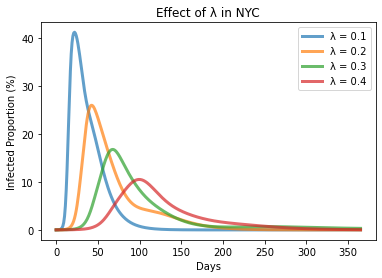

In [74]:
# NYC Lambda Test
# 0.1 less strict  >>> 0.4 stricter

for lambdas in range(4):
    strictness += 0.1
    strictness = round(strictness, 1)

    mitigation_factor =  strictness/CITY_CASE_RATE
    NYC_resultant = np.matmul(mitigation_factor * CONTACT_MATRIX, np.diag(NYC_AGE_POP)) 
    NYC_eigvals, NYC_eigvecs = np.linalg.eig(NYC_resultant)
    NYC_lambda = max(NYC_eigvals) # dominant eigenvalue
    beta = Rnaught * gamma / NYC_lambda
    totalI= 0
    
    for idx in range(len(CONTACT_MATRIX)):
        # Integrate the SIR equations over the time grid, t.
        S0 = N * NYC_AGE_POP[idx]
        y0 = S0, I0, R0 # Initial conditions vector
        
        ret = odeint(deriv, y0, t, 
                     args=(N*NYC_AGE_POP[idx], beta, gamma, summationOfGroup(CONTACT_MATRIX, idx, NYC_GRP_RATE)))

        S, I, R = (ret.T / N) * 100
        totalI += I
    plot(t, totalI, "λ = " + str(strictness), "Effect of λ in NYC")

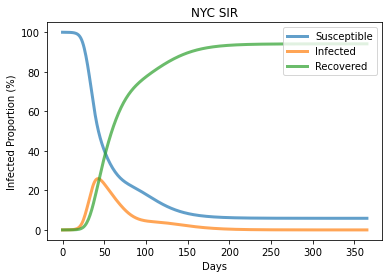

In [75]:
# SIR Plot with strictness of 0.2
strictness = 0.2

mitigation_factor =  strictness/CITY_CASE_RATE
NYC_resultant = np.matmul(mitigation_factor * CONTACT_MATRIX, np.diag(NYC_AGE_POP)) 
NYC_eigvals, NYC_eigvecs = np.linalg.eig(NYC_resultant)
NYC_lambda = max(NYC_eigvals) # dominant eigenvalue
beta = Rnaught * gamma / NYC_lambda
totalS = totalI = totalR = 0

for idx in range(len(CONTACT_MATRIX)):
    # Integrate the SIR equations over the time grid, t.
    S0 = N * NYC_AGE_POP[idx]
    y0 = S0, I0, R0 # Initial conditions vector

    ret = odeint(deriv, y0, t, 
                 args=(N*NYC_AGE_POP[idx], beta, gamma, summationOfGroup(CONTACT_MATRIX, idx, NYC_GRP_RATE)))

    S, I, R = (ret.T / N) * 100
    totalS += S
    totalI += I
    totalR += R
    
plot(t, totalS, "Susceptible", "NYC SIR")
plot(t, totalI, "Infected", "NYC SIR")
plot(t, totalR, "Recovered", "NYC SIR")

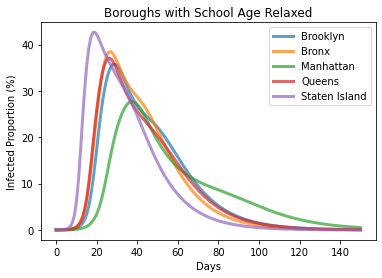

In [76]:
t = np.linspace(0, 150, 150)


# Relaxing School Age Bracket (<30 Years) - All Boroughs

CM_SCHOOL_RELAXED = CONTACT_MATRIX.copy()
r = range(0,3)
mitigation_factor =  strictness/CITY_CASE_RATE

for i in range(len(CM_SCHOOL_RELAXED)):
    for j in range(len(CM_SCHOOL_RELAXED)):
        if not (i in r and j in r):
            CM_SCHOOL_RELAXED[i,j] *= mitigation_factor # MF only applies to working age

            
# Brooklyn            
brooklynSch_totalI = integration(CM_SCHOOL_RELAXED, BROOKLYN_AGE_POP, BROOKLYN_GRP_RATE)
plot(t, brooklynSch_totalI, "Brooklyn", "Boroughs with School Age Relaxed")

# Bronx
bronxSch_totalI = integration(CM_SCHOOL_RELAXED, BRONX_AGE_POP, BRONX_GRP_RATE)    
plot(t, bronxSch_totalI, "Bronx", "Boroughs with School Age Relaxed")

# Manhattan
manhattanSch_totalI = integration(CM_SCHOOL_RELAXED, MANHATTAN_AGE_POP, MANHATTAN_GRP_RATE)
plot(t, manhattanSch_totalI, "Manhattan", "Boroughs with School Age Relaxed")

# Queens
queensSch_totalI = integration(CM_SCHOOL_RELAXED, QUEENS_AGE_POP, QUEENS_GRP_RATE)
plot(t, queensSch_totalI, "Queens", "Boroughs with School Age Relaxed")

# Staten Island
siSch_totalI = integration(CM_SCHOOL_RELAXED, SI_AGE_POP, SI_GRP_RATE)
plot(t, siSch_totalI, "Staten Island", "Boroughs with School Age Relaxed")

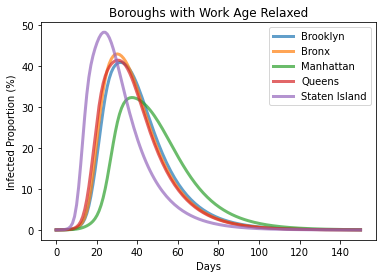

In [77]:
# Relaxing Work Age Bracket (<60 Years) - All Boroughs
CM_WORK_RELAXED = CONTACT_MATRIX.copy()
r = range(0,6)
mitigation_factor =  strictness/CITY_CASE_RATE

for i in range(len(CM_WORK_RELAXED)):
    for j in range(len(CM_WORK_RELAXED)):
        if not (i in r and j in r):
            CM_WORK_RELAXED[i,j] *= mitigation_factor # MF only applies to working age
            
# Brooklyn            
brooklynWrk_totalI = integration(CM_WORK_RELAXED, BROOKLYN_AGE_POP, BROOKLYN_GRP_RATE)  
plot(t, brooklynWrk_totalI, "Brooklyn", "Boroughs with Work Age Relaxed")

# Bronx
bronxWrk_totalI = integration(CM_WORK_RELAXED, BRONX_AGE_POP, BRONX_GRP_RATE)
plot(t, bronxWrk_totalI, "Bronx", "Boroughs with Work Age Relaxed")

# Manhattan
manhattanWrk_totalI = integration(CM_WORK_RELAXED, MANHATTAN_AGE_POP, MANHATTAN_GRP_RATE)
plot(t, manhattanWrk_totalI, "Manhattan", "Boroughs with Work Age Relaxed")

# Queens
queensWrk_totalI = integration(CM_WORK_RELAXED, QUEENS_AGE_POP, QUEENS_GRP_RATE)
plot(t, queensWrk_totalI, "Queens", "Boroughs with Work Age Relaxed")

# Staten Island
siWrk_totalI = integration(CM_WORK_RELAXED, SI_AGE_POP, SI_GRP_RATE)
plot(t, siWrk_totalI, "Staten Island", "Boroughs with Work Age Relaxed")